In [7]:
import os
import csv
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading the files with review json data

In [8]:
path = "reviews.csv" #Reading the review files

In [9]:
df_final = pd.read_csv(path)

In [12]:
df_final.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [13]:
df_final[df_final['label'] == 0]

,review_id,app_id,review_text,label
9,136818373,1364020,everyone uses one class thats not fun needs mo...,0
14,136819175,"1,79,80,10,17,98,020",Got up to the second boss in MMBN1 (Numberman)...,0
16,136824052,1798010,I love the game but this port frequently freez...,0
28,136819099,2114350,poop,0
31,136822876,2328760,"Can't stand the feel. Solid visual upgrade, b...",0
...,...,...,...,...
979,137380782,1493750,Schemer demon is broken to fight against as a ...,0
980,137379732,1493750,Unfair matchmaking. Clunky beyond words. And g...,0
992,137380202,2360030,18 years and I still don't know what the myste...,0
1002,137378370,1861630,"""Junk Survivor"" couldn't have a more fitting n...",0


In [14]:
plt.style.use('ggplot')

#### Looking at label counts

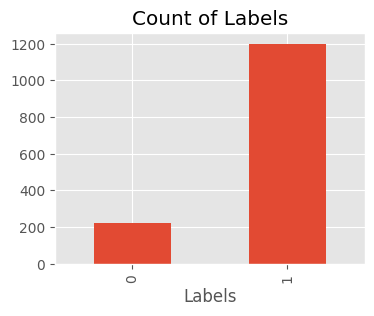

In [15]:
ax = df_final['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Labels',
          figsize=(4, 3))
ax.set_xlabel('Labels')
plt.show()

In [16]:
df = df_final.drop_duplicates()

In [37]:
df = spark.createDataFrame(df)

C:\Users\rahul\spark\spark-3.3.2-bin-hadoop2\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\rahul\spark\spark-3.3.2-bin-hadoop2\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [40]:
df.show(10)

+---------+-------+--------------------+-----+
|review_id| app_id|         review_text|label|
+---------+-------+--------------------+-----+
|136820163|1097620|after playing thi...|    1|
|136820275|2328760|Good game, graphi...|    1|
|136820498|1364020|What a great game...|    1|
|136820495|1364020|            Me enjoy|    1|
|136820488|1364020|Better than Cod a...|    1|
|136820298|1364020|Interesting gamep...|    1|
|136820246|1364020|         Fun shooter|    1|
|136819180|1364020|Its a very differ...|    1|
|136819065|1364020|Fun game, think m...|    1|
|136818373|1364020|everyone uses one...|    0|
+---------+-------+--------------------+-----+
only showing top 10 rows



### Now, we will create a pipeline using pyspark to preprocess the text data and then make sentiment predictions

In [41]:
import pyspark.ml.feature

In [42]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF

In [57]:
#Parts of the pipeline

tokenize = Tokenizer(inputCol='review_text', outputCol='tok_reviews')
stopwrem = StopWordsRemover(inputCol='tok_reviews', outputCol='clean_rev')
vec_data = CountVectorizer(inputCol='clean_rev', outputCol='vec_rev')
idf = IDF(inputCol='vec_rev', outputCol='vec_features')

In [44]:
labs = {0:"Negative", 1:"Positive"}

In [45]:
from sklearn.model_selection import train_test_split

In [47]:
train_df,test_df = df.randomSplit((0.7,0.3),seed=10)

In [50]:
train_df.show(10)

+---------+--------------------+--------------------+-----+
|review_id|              app_id|         review_text|label|
+---------+--------------------+--------------------+-----+
|136817493|1,79,80,10,17,98,020|             Megaman|    1|
|136817509|             1922010|        Simply great|    1|
|136817799|             1651560|I want the mixed ...|    1|
|136818046|             1922010|If the devs add t...|    1|
|136818916|             1922010|Solid gun play. E...|    1|
|136819099|             2114350|                poop|    0|
|136819175|1,79,80,10,17,98,020|Got up to the sec...|    0|
|136819222|             2097410|great game, you s...|    1|
|136819285|             1922010|worth the money, ...|    1|
|136819930|             1797630|Using Mime on the...|    1|
+---------+--------------------+--------------------+-----+
only showing top 10 rows



In [51]:
test_df.show(10)

+---------+-------+--------------------+-----+
|review_id| app_id|         review_text|label|
+---------+-------+--------------------+-----+
|136817494|1922010|  R6 in VR FUCK YESS|    1|
|136817733|2329130|TLDR: Its good, i...|    1|
|136818080|1798020|Please buy this g...|    1|
|136818373|1364020|everyone uses one...|    0|
|136818823|2329130|This is a pretty ...|    1|
|136819065|1364020|Fun game, think m...|    1|
|136819180|1364020|Its a very differ...|    1|
|136819922|1911360|What an amazing r...|    1|
|136820488|1364020|Better than Cod a...|    1|
|136821017|1941780|fun would be more...|    1|
+---------+-------+--------------------+-----+
only showing top 10 rows



In [52]:
from pyspark.ml.classification import LogisticRegression

In [53]:
from pyspark.ml import Pipeline

In [54]:
lr = LogisticRegression(featuresCol='vec_features', labelCol='label')

In [55]:
pipeline = Pipeline(stages=[tokenize, stopwrem, vec_data, idf, lr])

In [58]:
lr_model = pipeline.fit(train_df)

In [59]:
predictions = lr_model.transform(test_df)

In [61]:
predictions.columns

['review_id',
 'app_id',
 'review_text',
 'label',
 'tok_reviews',
 'clean_rev',
 'vec_rev',
 'vec_features',
 'rawPrediction',
 'probability',
 'prediction']

In [71]:
predictions.select('review_id','review_text', 'label', 'rawPrediction', 'probability', 'prediction').show(80)

+---------+--------------------+-----+--------------------+--------------------+----------+
|review_id|         review_text|label|       rawPrediction|         probability|prediction|
+---------+--------------------+-----+--------------------+--------------------+----------+
|136817494|  R6 in VR FUCK YESS|    1|[-24.740333422431...|[1.80056877389267...|       1.0|
|136817733|TLDR: Its good, i...|    1|[-26.471650765141...|[3.18792536933547...|       1.0|
|136818080|Please buy this g...|    1|[-12.318582481354...|[4.46792282700155...|       1.0|
|136818373|everyone uses one...|    0|[-21.371926920817...|[5.22745220141907...|       1.0|
|136818823|This is a pretty ...|    1|[-19.525008254887...|[3.31433691750267...|       1.0|
|136819065|Fun game, think m...|    1|[-11.624192933874...|[8.9469140785241E...|       1.0|
|136819180|Its a very differ...|    1|[-17.434795360599...|[2.68018375253522...|       1.0|
|136819922|What an amazing r...|    1|[-48.350010943804...|[1.00428516424144...|

In [68]:
predictions.select('prediction').show(100)

+----------+
|prediction|
+----------+
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
|       1.0|
|       0.0|
|       1.0|
|       0.0|
|       1.0|

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')

accuracy = evaluator.evaluate(predictions)


In [73]:
accuracy

0.7750865051903114

### Confusion matrix to visualise the results

In [80]:
from sklearn.metrics import confusion_matrix,classification_report

In [81]:
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()
cm = confusion_matrix(y_true,y_pred)

In [82]:
cm

array([[ 19,  25],
       [ 40, 205]], dtype=int64)

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [84]:
class_names = ['Negative','Positive']

Confusion matrix, without normalization
[[ 19  25]
 [ 40 205]]


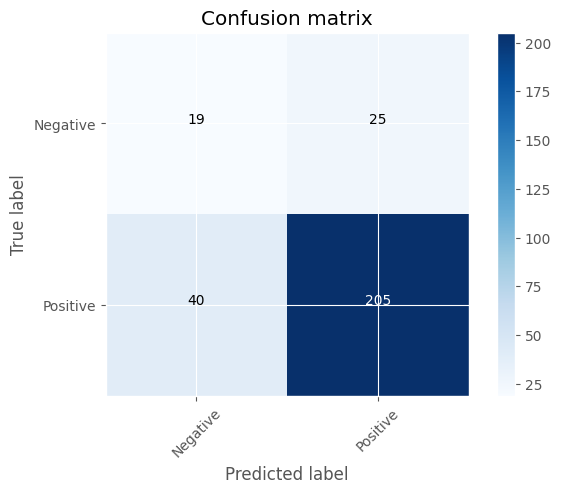

In [85]:
plot_confusion_matrix(cm,class_names)

### Example prediction

In [86]:
from pyspark.sql.types import StringType

In [95]:
ex = spark.createDataFrame([("Worst game ever",StringType())], ["review_text"])

In [96]:
pred_ex = lr_model.transform(ex)

In [97]:
pred_ex.select('review_text', 'rawPrediction', 'probability', 'prediction').show()

+---------------+--------------------+--------------------+----------+
|    review_text|       rawPrediction|         probability|prediction|
+---------------+--------------------+--------------------+----------+
|Worst game ever|[1.38596476617394...|[0.79994725959423...|       0.0|
+---------------+--------------------+--------------------+----------+



### Save the model

In [75]:
Path = "D:\\Rahul\\Stats and Data Science\\Sem 2\\Advanced Analytics\\Assignments\\Game Reviews Model"
lr_model.save(Path)